# Electricity Consumption Prediction (ECP)

In this project we're going to predict electricity consumption of each user for future periods.

Here is some info and stats about the data:
* **Number of unique users: 124675**
* **Total number of records: 5601193**

Also you can find `headers.xslx` file in `dataset` directory to find some more descriptions about the header names or features.

In [1]:
# Import required packages

import datetime
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from persiantools.jdatetime import JalaliDate

%matplotlib inline

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## 1.1. Peek at Our Data

There is no substitute for looking at the raw data.

Looking at the raw data can reveal insights that you cannot get any other way. It can also plant seeds that may later grow into ideas on how to better preprocess and handle the data for machine learning tasks.

We can review the first 5 rows of our data here.

In [11]:
# Load the dataset
df = pd.read_csv("../dataset/dbBills.csv")

# Print top 5 reeocrds of dataset
df.head()

,xSubscriptionId_fk,xIdentityNo,xOmorCode,xBakhshCode,xCycleCode,xMamorCode,xRegionName,xIsTropical,xUsageGroupName,xFamilyNum,xTariffOldCode,xFaze,xAmper,xCounterBuldingNo,xTimeControlCode,xBillStartDate,xBillEndDate,xMeduimKw,xHighKw,xLowKw
0,9397665,2/6/15/01/25/10/7651,15,1,25,10,شهری,0,عمومي,1,2990,3,25,12606909,1,1391/08/25,1391/09/09,538,0,0
1,9396214,2/6/15/01/44/10/4321,15,1,44,10,شهری,0,عمومي,1,2990,3,25,8336853341,1,1391/08/18,1391/09/09,1999,0,0
2,9396214,2/6/15/01/44/10/4321,15,1,44,10,شهری,0,عمومي,1,2990,3,25,8336853341,1,1391/09/09,1391/10/03,0,0,0
3,8952093,2/6/15/04/32/04/4870,15,4,32,4,روستایی,0,عمومي,1,2990,3,25,37337459,1,1386/11/27,1387/02/05,1065,0,0
4,8952093,2/6/15/04/32/04/4870,15,4,32,4,روستایی,0,عمومي,1,2990,3,25,37337459,1,1387/02/05,1387/04/05,560,0,0


We can see that the first column lists the row number, which is handy for referencing a specific observation.

## 1.2. Dimensions of Our Data

We must have a very good handle on how much data we have, both in terms of rows and columns.

Too many rows and algorithms may take too long to train. Too few and perhaps you do not have enough data to train the algorithms.
Too many features and some algorithms can be distracted or suffer poor performance due to the curse of dimensionality.
You can review the shape and size of your dataset by printing the shape property.

In [21]:
# Dimensions of your data
print("Our data has dimention of {} Records and {} Columns or Features.".format(df.shape[0], df.shape[1]))

Our data has dimention of 5601193 Records and 20 Columns or Features.


## 1.3. Data Type For Each Attribute

The type of each attribute is important.

Strings may need to be converted to floating point values or integers to represent categorical or ordinal values.

We can get an idea of the types of attributes by peeking at the raw data, as above. We can also list the data types used by the DataFrame to characterize each attribute using the dtypes property.

In [22]:
# Data Types for Each Attribute
types = df.dtypes
types.head(20)

xSubscriptionId_fk     int64
xIdentityNo           object
xOmorCode              int64
xBakhshCode            int64
xCycleCode             int64
xMamorCode             int64
xRegionName           object
xIsTropical            int64
xUsageGroupName       object
xFamilyNum             int64
xTariffOldCode         int64
xFaze                  int64
xAmper                 int64
xCounterBuldingNo      int64
xTimeControlCode       int64
xBillStartDate        object
xBillEndDate          object
xMeduimKw              int64
xHighKw                int64
xLowKw                 int64
dtype: object

We can see that most of the attribute types are objects (categorical string values).

## 1.4. Data Cleaning and Transformation

For apply more effective analysis on data we need to reshape our data. So we transform categorical data to numbers using one-hot encoding and fill **NaN** valuses with average amount as a way for data cleaning.

In [23]:
# Utils

def days_difference(start_date, end_date):    
    start_date = start_date.split("/")
    end_date = end_date.split("/")
    
    jalali_start_date = JalaliDate(int(start_date[0]), int(start_date[1]), int(start_date[2]))
    jalali_end_date = JalaliDate(int(end_date[0]), int(end_date[1]), int(end_date[2]))

    difference = jalali_end_date.to_gregorian() - jalali_start_date.to_gregorian()
    
    return difference.days

def extract_month(input_date):
    return int(input_date.split("/")[1])

In [24]:
# Clean Dataset

df = df.drop('xIsTropical', 1) # Since it's a constant value
df = df.drop('xOmorCode', 1) # Since it's a constant value
df = df.drop('xIdentityNo', 1) # Since we can use other decomposed fields.
df = df.drop('xMamorCode', 1) # It seems there is no useful information in this field

# Map Persian strings to English strings for field: 'xRegionName'
region_maps = {'شهری': 'Shahri', 'روستایی': 'Roustaei'}
df['xRegionName'].replace(region_maps, inplace=True)
# One-Hot Encoding on categorical values
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['xRegionName'], prefix='xRegionName')],axis=1)
df = df.drop('xRegionName', 1) # Since we can use one-hot encoded features instead

# Map Persian strings to English strings for field: 'xUsageGroupName'
usage_group_maps = {'عمومي': 'Omoomi',
                    'خانگي': 'Khanegi',
                    'كشاورزي': 'Keshavarzi',
                    'ساير مصارف': 'Sayer',
                    'صنعتي': 'Sanati'}
df['xUsageGroupName'].replace(usage_group_maps, inplace=True)
# One-Hot Encoding on categorical values
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['xUsageGroupName'], prefix='xUsageGroupName')],axis=1)
df = df.drop('xUsageGroupName', 1) # Since we can use one-hot encoded features instead

# One-Hot Encoding on categorical values
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['xBakhshCode'], prefix='xBakhshCode')],axis=1)
df = df.drop('xBakhshCode', 1) # Since we can use one-hot encoded features instead

# One-Hot Encoding on categorical values
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['xTimeControlCode'], prefix='xTimeControlCode')],axis=1)
df = df.drop('xTimeControlCode', 1) # Since we can use one-hot encoded features instead

# One-Hot Encoding on categorical values
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['xTariffOldCode'], prefix='xTariffOldCode')],axis=1)
df = df.drop('xTariffOldCode', 1) # Since we can use one-hot encoded features instead

# Adding new features using 'xBillStartDate' and 'xBillEndDate'.
df['days_difference'] = df.apply(lambda row: days_difference(row.xBillStartDate, row.xBillEndDate), axis=1)
df['month'] = df.apply(lambda row: extract_month(row.xBillStartDate), axis=1)

# Adding 3 new fields to dataset for calculating daily usage of users.
df['mediumDailyUsage'] = df['xMeduimKw']/df['days_difference']
df['highDailyUsage'] = df['xHighKw']/df['days_difference']
df['lowDailyUsage'] = df['xLowKw']/df['days_difference']

df = df.drop('xBillStartDate', 1) # Since we've extracted useful parts before
df = df.drop('xBillEndDate', 1) # Since we've extracted useful parts before

# Move target or labels to the end of dataset
xMeduimKw_tmp = df.pop('xMeduimKw') # remove column xMeduimKw and store it in xMeduimKw_tmp
xHighKw_tmp = df.pop('xHighKw') # remove column xHighKw and store it in xHighKw_tmp
xLowKw_tmp = df.pop('xLowKw') # remove column xLowKw and store it in xLowKw_tmp

df['xMeduimKw']=xMeduimKw_tmp # add xMeduimKw series as a 'new' column.
df['xHighKw']=xHighKw_tmp # add xMeduimKw series as a 'new' column.
df['xLowKw']=xLowKw_tmp # add xMeduimKw series as a 'new' column.

# Save cleaned dataset for using in later analysis
df.to_csv('../dataset/dbBills_cleaned.csv')

In [6]:
# Normalize values between [0, 1]
# TODO: Develop a function. We have code redundancy here!

df["xMeduimKw"] = df["xMeduimKw"] / df["xMeduimKw"].max()
df["xHighKw"] = df["xHighKw"] / df["xHighKw"].max()
df["xLowKw"] = df["xLowKw"] / df["xLowKw"].max()

df["mediumDailyUsage"] = df["mediumDailyUsage"] / df["mediumDailyUsage"].max()
df["highDailyUsage"] = df["highDailyUsage"] / df["highDailyUsage"].max()
df["lowDailyUsage"] = df["lowDailyUsage"] / df["lowDailyUsage"].max()

df["month"] = df["month"] / df["month"].max()

df["days_difference"] = df["days_difference"] / df["days_difference"].max()

df["xFaze"] = df["xFaze"] / df["xFaze"].max()

df["xAmper"] = df["xAmper"] / df["xAmper"].max()

df["xFamilyNum"] = df["xFamilyNum"] / df["xFamilyNum"].max()

df["xCycleCode"] = df["xCycleCode"] / df["xCycleCode"].max()

df = df.drop(df.columns[[0]], 1)

df.to_csv('../dataset/dbBills_normalized.csv')

# Please do not remove this lines.
##############################################################################################
# column_names = list(df.columns.values)

# min_max_scaler = preprocessing.MinMaxScaler()

# column_names_to_not_normalize = ['xSubscriptionId_fk']
# column_names_to_normalize = [x for x in list(df) if x not in column_names_to_not_normalize ]
# x = df[column_names_to_normalize].values
# x_scaled = min_max_scaler.fit_transform(x)
# df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
# df[column_names_to_normalize] = df_temp

# df.columns = column_names
# Save cleaned dataset for using in later analysis
################################################################################################

In [20]:
# Load the cleaned dataset
# df = pd.read_csv("../dataset/dbBills_cleaned.csv")
df = pd.read_csv("../dataset/dbBills_normalized.csv")

# Print top 5 reeocrds of dataset
df.head()

,Unnamed: 0,xSubscriptionId_fk,xCycleCode,xFamilyNum,xFaze,xAmper,xCounterBuldingNo,xRegionName_Roustaei,xRegionName_Shahri,xUsageGroupName_Keshavarzi,xUsageGroupName_Khanegi,xUsageGroupName_Omoomi,xUsageGroupName_Sanati,xUsageGroupName_Sayer,xBakhshCode_1,xBakhshCode_2,xBakhshCode_4,xTimeControlCode_1,xTimeControlCode_2,xTimeControlCode_3,xTariffOldCode_1010,xTariffOldCode_1011,xTariffOldCode_1110,xTariffOldCode_1111,xTariffOldCode_1990,xTariffOldCode_2110,xTariffOldCode_2210,xTariffOldCode_2310,xTariffOldCode_2410,xTariffOldCode_2510,xTariffOldCode_2610,xTariffOldCode_2710,xTariffOldCode_2990,xTariffOldCode_2992,xTariffOldCode_3110,xTariffOldCode_3210,xTariffOldCode_3310,xTariffOldCode_3410,xTariffOldCode_3520,xTariffOldCode_3540,xTariffOldCode_3740,xTariffOldCode_3991,xTariffOldCode_4410,xTariffOldCode_4610,xTariffOldCode_4990,xTariffOldCode_5110,xTariffOldCode_5990,days_difference,month,mediumDailyUsage,highDailyUsage,lowDailyUsage,xMeduimKw,xHighKw,xLowKw
0,0,9397665,0.520833,0.25,1.0,0.78125,12606909,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.003591,0.666667,0.0,0.0,0.0,0.004881,0.0,0.0
1,1,9396214,0.916667,0.25,1.0,0.78125,8336853341,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.005386,0.666667,0.0,0.0,0.0,0.018136,0.0,0.0
2,2,9396214,0.916667,0.25,1.0,0.78125,8336853341,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006155,0.750000,0.0,0.0,0.0,0.000000,0.0,0.0
3,3,8952093,0.666667,0.25,1.0,0.78125,37337459,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.017440,0.916667,0.0,0.0,0.0,0.009662,0.0,0.0
4,4,8952093,0.666667,0.25,1.0,0.78125,37337459,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.015902,0.166667,0.0,0.0,0.0,0.005081,0.0,0.0


## 1.5. Descriptive Statistics

Descriptive statistics can give you great insight into the shape of each attribute.

Often you can create more summaries than you have time to review. The describe() function on the Pandas DataFrame lists 8 statistical properties of each attribute:

* **Count**
* **Mean**
* **Standard Devaition**
* **Minimum Value**
* **25th Percentile**
* **50th Percentile (Median)**
* **75th Percentile**
* **Maximum Value**

In [8]:
df.describe()

,Unnamed: 0,xSubscriptionId_fk,xCycleCode,xFamilyNum,xFaze,xAmper,xCounterBuldingNo,xRegionName_Roustaei,xRegionName_Shahri,xUsageGroupName_Keshavarzi,xUsageGroupName_Khanegi,xUsageGroupName_Omoomi,xUsageGroupName_Sanati,xUsageGroupName_Sayer,xBakhshCode_1,xBakhshCode_2,xBakhshCode_4,xTimeControlCode_1,xTimeControlCode_2,xTimeControlCode_3,xTariffOldCode_1010,xTariffOldCode_1011,xTariffOldCode_1110,xTariffOldCode_1111,xTariffOldCode_1990,xTariffOldCode_2110,xTariffOldCode_2210,xTariffOldCode_2310,xTariffOldCode_2410,xTariffOldCode_2510,xTariffOldCode_2610,xTariffOldCode_2710,xTariffOldCode_2990,xTariffOldCode_2992,xTariffOldCode_3110,xTariffOldCode_3210,xTariffOldCode_3310,xTariffOldCode_3410,xTariffOldCode_3520,xTariffOldCode_3540,xTariffOldCode_3740,xTariffOldCode_3991,xTariffOldCode_4410,xTariffOldCode_4610,xTariffOldCode_4990,xTariffOldCode_5110,xTariffOldCode_5990,days_difference,month,mediumDailyUsage,highDailyUsage,lowDailyUsage,xMeduimKw,xHighKw,xLowKw
count,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5.601193e+06,5601072.0,5601072.0,5601072.0,5.601193e+06,5.601193e+06,5.601193e+06
mean,2.800596e+06,4.447717e+06,4.839020e-01,2.505622e-01,3.656579e-01,6.939119e-01,9.141535e+11,7.715267e-02,9.228473e-01,6.286161e-04,8.442021e-01,5.297621e-02,1.540922e-03,1.006521e-01,7.658010e-01,9.062551e-02,1.435735e-01,5.905958e-01,1.785334e-07,4.094040e-01,8.371358e-01,1.480042e-04,6.161187e-03,7.414492e-04,1.571094e-05,1.263838e-03,4.302673e-02,6.179219e-03,5.654153e-04,1.310435e-04,5.659509e-04,1.221704e-03,6.070135e-06,1.624654e-05,2.892241e-05,2.945801e-05,2.558384e-04,1.114048e-04,1.219383e-04,5.802335e-05,1.481827e-05,8.212536e-06,1.536280e-03,1.963867e-06,2.678001e-06,9.481980e-02,5.832329e-03,1.689576e-02,5.275828e-01,0.0,0.0,0.0,3.019614e-03,9.945436e-04,4.707192e-04
std,1.616925e+06,4.284231e+06,2.804173e-01,1.302832e-02,1.431951e-01,1.632332e-01,4.273449e+13,2.668336e-01,2.668336e-01,2.506434e-02,3.626637e-01,2.239860e-01,3.922432e-02,3.008676e-01,4.234972e-01,2.870759e-01,3.506568e-01,4.917240e-01,4.225321e-04,4.917239e-01,3.692418e-01,1.216480e-02,7.825106e-02,2.721947e-02,3.963672e-03,3.552803e-02,2.029173e-01,7.836477e-02,2.377174e-02,1.144667e-02,2.378299e-02,3.493153e-02,2.463757e-03,4.030667e-03,5.377879e-03,5.427444e-03,1.599290e-02,1.055426e-02,1.104190e-02,7.617086e-03,3.849423e-03,2.865741e-03,3.916529e-02,1.401379e-03,1.636458e-03,2.929659e-01,7.614666e-02,8.280924e-03,2.797440e-01,0.0,0.0,0.0,4.181191e-03,2.780709e-03,1.377721e-03
min,0.000000e+00,1.100010e+05,2.083333e-02,2.500000e-01,3.333333e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.333333e-02,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400298e+06,1.501520e+05,2.500000e-01,2.500000e-01,3.333333e-01,4.687500e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+0

We can see that we do get a lot of data. We will note some functio calls in the recipe to change the precision of the numbers and the preferred width of the output. This is to make it more readable for this example.

When describing our data this way, it is worth taking some time and reviewing observations from the results. This might include the presence of “NA” values for missing data or surprising distributions for attributes. We can see Box-Plot chart for 4 selected features as following. This charts will help us to detect outliers.

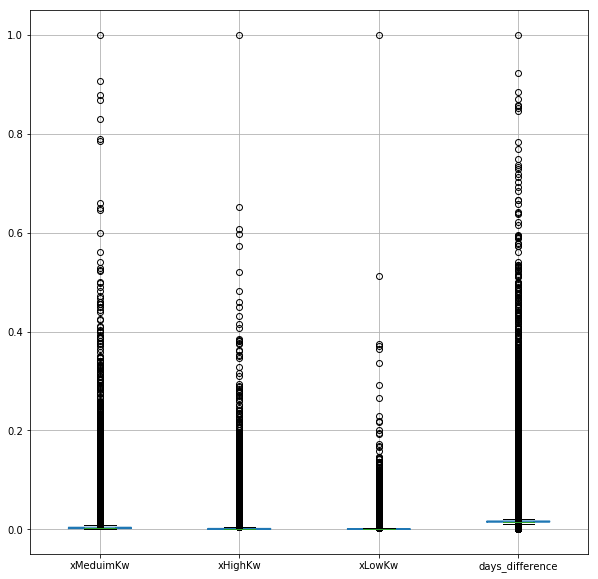

In [9]:
boxplot = df.boxplot(column=['xMeduimKw', 'xHighKw', 'xLowKw', 'days_difference'], 
                                   return_type='axes', 
                                   figsize=(10,10),
                                   notch = True
                                  )

### Interpreting the Box-Plot chart for weights

A box and whisker plot—also called a box plot—displays the five-number summary of a set of data. The five-number summary is the minimum, first quartile, median, third quartile, and maximum.

In a box plot, we draw a box from the first quartile to the third quartile. A vertical line goes through the box at the median. The whiskers go from each quartile to the minimum or maximum.

## 1.6. Class Distribution (Classification Only)

On classification problems we need to know how balanced the class values are.

Highly imbalanced problems (a lot more observations for one class than another) are common and may need special handling in the data preparation stage of your project.

We can quickly get an idea of the distribution of the class attribute here.

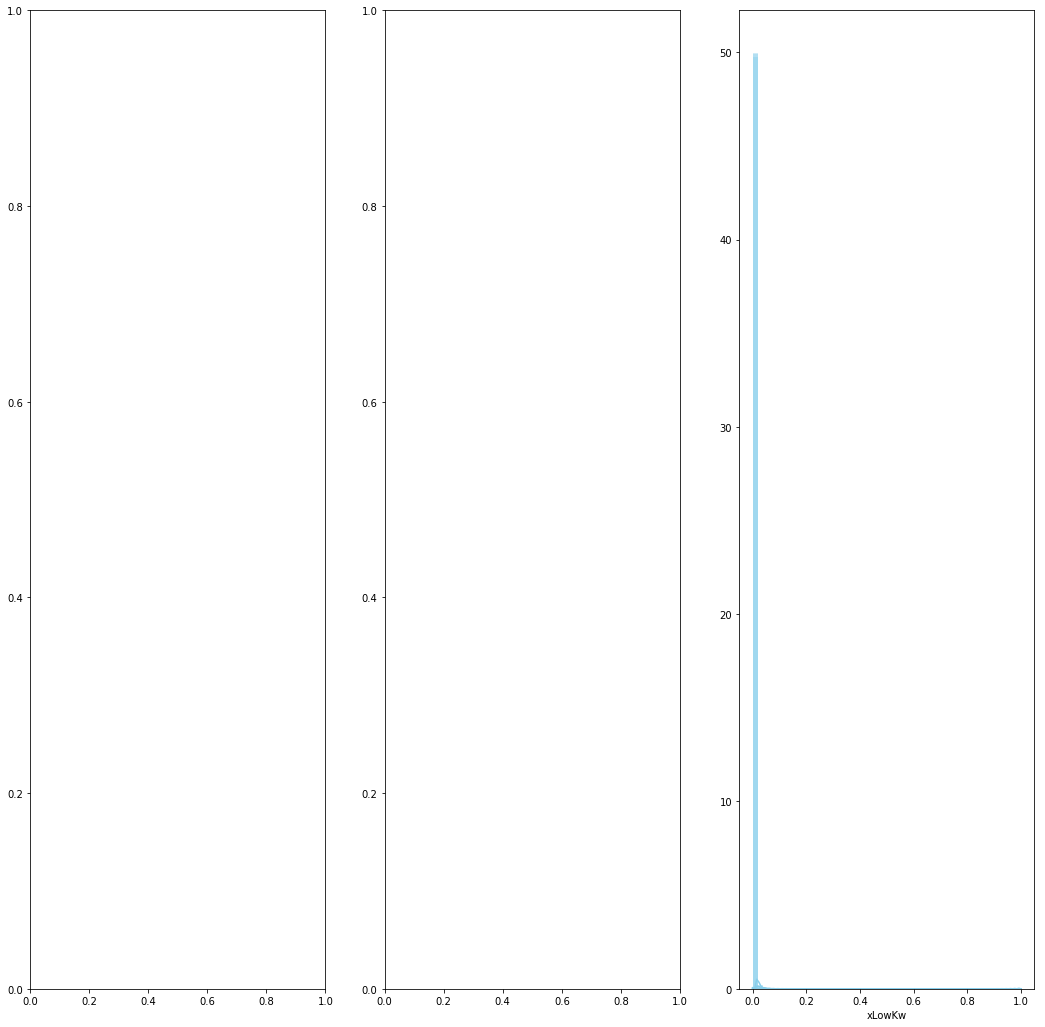

In [10]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(18, 18)

sns.distplot(df["xMeduimKw"] , color="skyblue", label="xMeduimKw")
sns.distplot(df["xHighKw"] , color="skyblue", label="xHighKw")
sns.distplot(df["xLowKw"] , color="skyblue", label="xLowKw")

1.7. Correlation Between Attributes
Correlation refers to the relationship between two variables and how they may or may not change together.

The most common method for calculating correlation is Pearson’s Correlation Coefficient, that assumes a normal distribution of the attributes involved. A correlation of -1 or 1 shows a full negative or positive correlation respectively. Whereas a value of 0 shows no correlation at all.

Some machine learning algorithms like linear and logistic regression can suffer poor performance if there are highly correlated attributes in your dataset. As such, it is a good idea to review all of the pair-wise correlations of the attributes in your dataset. We can use below code snippet to calculate a correlation matrix.

In [11]:
correlations = df.corr(method='pearson')

The matrix lists all attributes across the top and down the side, to give correlation between all pairs of attributes (twice, because the matrix is symmetrical). We can see the diagonal line through the matrix from the top left to bottom right corners of the matrix shows perfect correlation of each attribute with itself.

In [12]:
correlations.head()

,Unnamed: 0,xSubscriptionId_fk,xCycleCode,xFamilyNum,xFaze,xAmper,xCounterBuldingNo,xRegionName_Roustaei,xRegionName_Shahri,xUsageGroupName_Keshavarzi,xUsageGroupName_Khanegi,xUsageGroupName_Omoomi,xUsageGroupName_Sanati,xUsageGroupName_Sayer,xBakhshCode_1,xBakhshCode_2,xBakhshCode_4,xTimeControlCode_1,xTimeControlCode_2,xTimeControlCode_3,xTariffOldCode_1010,xTariffOldCode_1011,xTariffOldCode_1110,xTariffOldCode_1111,xTariffOldCode_1990,xTariffOldCode_2110,xTariffOldCode_2210,xTariffOldCode_2310,xTariffOldCode_2410,xTariffOldCode_2510,xTariffOldCode_2610,xTariffOldCode_2710,xTariffOldCode_2990,xTariffOldCode_2992,xTariffOldCode_3110,xTariffOldCode_3210,xTariffOldCode_3310,xTariffOldCode_3410,xTariffOldCode_3520,xTariffOldCode_3540,xTariffOldCode_3740,xTariffOldCode_3991,xTariffOldCode_4410,xTariffOldCode_4610,xTariffOldCode_4990,xTariffOldCode_5110,xTariffOldCode_5990,days_difference,month,mediumDailyUsage,highDailyUsage,lowDailyUsage,xMeduimKw,xHighKw,xLowKw
Unnamed: 0,1.000000,-0.043853,0.005950,-0.010266,-0.068065,-0.048338,0.006027,0.050438,-0.050438,-0.028054,0.086451,-0.053438,-0.040291,-0.056835,-0.016099,-0.106687,0.106785,-0.002238,-0.000731,0.002239,0.104718,-0.002443,-0.086844,-0.017397,-0.003667,-0.060489,-0.022806,-0.034592,-0.040910,-0.011140,-0.040927,-0.010737,-0.002440,-0.006768,-0.009033,-0.009368,-0.009997,-0.018011,-0.018968,-0.000590,-0.006658,-0.004957,-0.040288,-0.001181,-0.000516,-0.027744,-0.117823,-0.000674,-0.001296,NaN,NaN,NaN,-0.033346,-0.022300,-0.015856
xSubscriptionId_fk,-0.043853,1.000000,0.034756,-0.040382,-0.055113,0.493541,-0.013613,-0.146419,0.146419,-0.003464,0.000433,-0.014087,-0.000616,0.010334,0.193787,-0.001998,-0.232407,-0.357799,0.000404,0.357799,-0.003170,-0.000618,0.018573,-0.004445,0.000661,-0.011742,0.005415,-0.042262,-0.006377,-0.001512,0.000973,-0.011584,0.002280,0.004905,-0.002213,0.002792,-0.001277,0.000479,-0.001733,-0.006585,-0.003856,0.003291,-0.000648,-0.001403,0.001940,0.003182,0.028589,-0.034202,0.010371,NaN,NaN,NaN,-0.092902,0.139800,0.143467
xCycleCode,0.005950,0.034756,1.000000,-0.010834,0.025898,0.020086,-0.002827,0.074222,-0.074222,-0.000390,-0.015220,0.015881,0.000315,0.006515,-0.010955,-0.058056,0.060760,-0.022336,-0.000007,0.022336,-0.015449,-0.001675,0.002416,0.000546,0.000218,-0.001157,0.015401,0.002795,0.002481,-0.001497,0.008283,0.000353,0.000965,0.000123,0.003981,0.003112,-0.002149,0.000992,-0.000683,-0.000433,-0.000437,-0.004066,0.000463,-0.002210,-0.001632,0.004313,0.009151,0.004874,0.042226,NaN,NaN,NaN,-0.015416,0.016022,0.015836
xFamilyNum,-0.010266,-0.040382,-0.010834,1.000000,-0.006184,-0.007591,-0.000884,-0.011168,0.011168,-0.001082,0.018472,-0.010114,-0.001695,-0.014425,-0.010581,0.036022,-0.016711,0.019751,-0.000018,-0.019751,0.018532,0.000038,-0.001865,-0.001175,0.008472,-0.001535,-0.009049,-0.003403,-0.001026,-0.000494,-0.001027,-0.001509,-0.000106,-0.000174,-0.000232,-0.000234,-0.000690,-0.000455,-0.000477,-0.000329,-0.000166,-0.000124,-0.001693,-0.000060,-0.000071,-0.013955,-0.003305,-0.003488,-0.000949,NaN,NaN,NaN,0.025690,-0.002591,-0.001799
xFaze,-0.068065,-0.055113,0.025898,-0.006184,1.000000,0.131550,-0.004342,-0.024520,0.024520,0.082318,-0.417983,0.315748,0.132262,0.244669,0.023799,-0.007807,-0.022351,-0.117636,0.001872,0.117634,-0.407164,-0.002746,-0.014651,-0.003798,0.009590,0.077176,0.285934,0.100624,0.025645,0.037934,0.019617,0.013378,0.010914,0.017443,0.017951,0.016999,0.045451,0.038097,0.039135,0.028616,0.017053,0.010375,0.131936,0.006208,0.007249,0.171053,0.308618,0.002952,0.002866,NaN,NaN,NaN,0.156011,0.203559,0.165398


We can also visualize correlations as a heatmap chart:

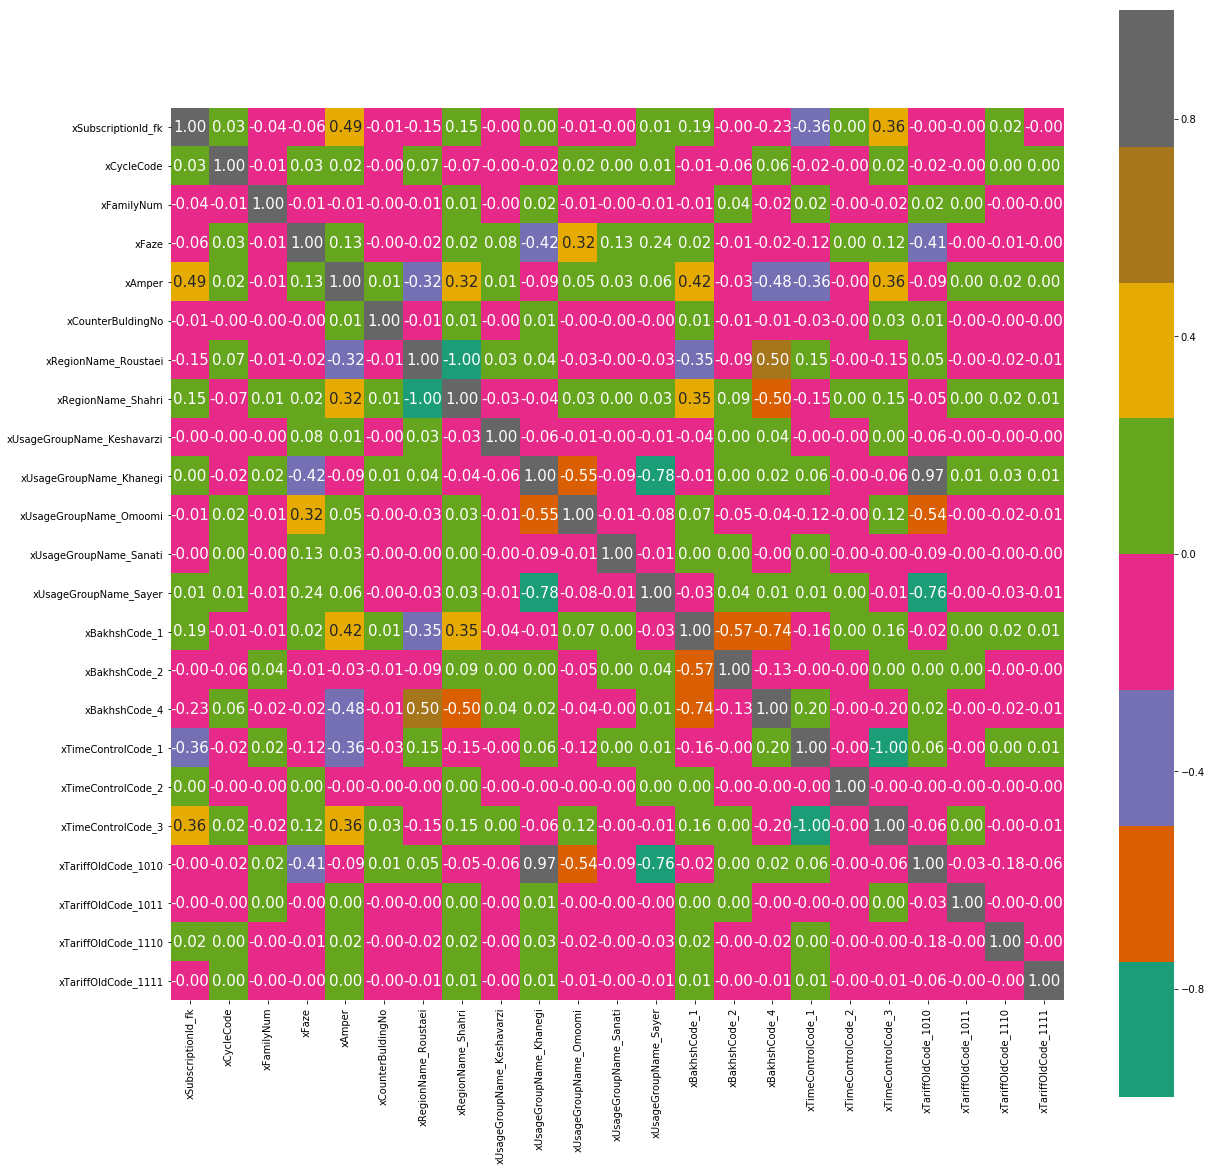

In [13]:
cols = df.columns.values[1:24]
corr_matrix = df[cols].corr()

plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(
    corr_matrix, 
    cbar=True, 
    annot=True, 
    square=True, 
    fmt='.2f', 
    annot_kws={'size': 15}, 
    yticklabels=cols, 
    xticklabels=cols, 
    cmap='Dark2'
)

### Heatmap chart interpretation

In this chart we can investigate amount of correlation between different features. For example correlation between **xHighKw** and **xLowKw** in this chart is **0.82** which means they are highly correlated and by increasing one, other one will be increased.

* ***Positive correlations between two feature means that with increasing one, other one will be increased.***
* ***Negative correlations between two feature means that with increasing one, other one will be decreased.***
* ***0 correlations between two feature means that they are uncorrelated.***

## 1.8. Skew of Univariate Distributions

Skew refers to a distribution that is assumed Gaussian (normal or bell curve) that is shifted or squashed in one direction or another.

Many machine learning algorithms assume a Gaussian distribution. Knowing that an attribute has a skew may allow we to perform data preparation to correct the skew and later improve the accuracy of your models.

We can calculate the skew of each attribute as following.

In [14]:
skew = df.skew()

The skew result show a positive (right) or negative (left) skew. Values closer to zero show less skew.

In [15]:
skew.head(25)

Unnamed: 0                   -1.012258e-15
xSubscriptionId_fk            1.520849e-01
xCycleCode                    5.503647e-02
xFamilyNum                    2.673460e+01
xFaze                         4.204180e+00
xAmper                       -1.513596e+00
xCounterBuldingNo             3.576482e+02
xRegionName_Roustaei          3.169373e+00
xRegionName_Shahri           -3.169373e+00
xUsageGroupName_Keshavarzi    3.984718e+01
xUsageGroupName_Khanegi      -1.898190e+00
xUsageGroupName_Omoomi        3.991534e+00
xUsageGroupName_Sanati        2.541582e+01
xUsageGroupName_Sayer         2.654643e+00
xBakhshCode_1                -1.255267e+00
xBakhshCode_2                 2.852031e+00
xBakhshCode_4                 2.032909e+00
xTimeControlCode_1           -3.684824e-01
xTimeControlCode_2            2.366684e+03
xTimeControlCode_3            3.684832e-01
xTariffOldCode_1010          -1.826098e+00
xTariffOldCode_1011           8.218010e+01
xTariffOldCode_1110           1.262191e+01
xTariffOldC

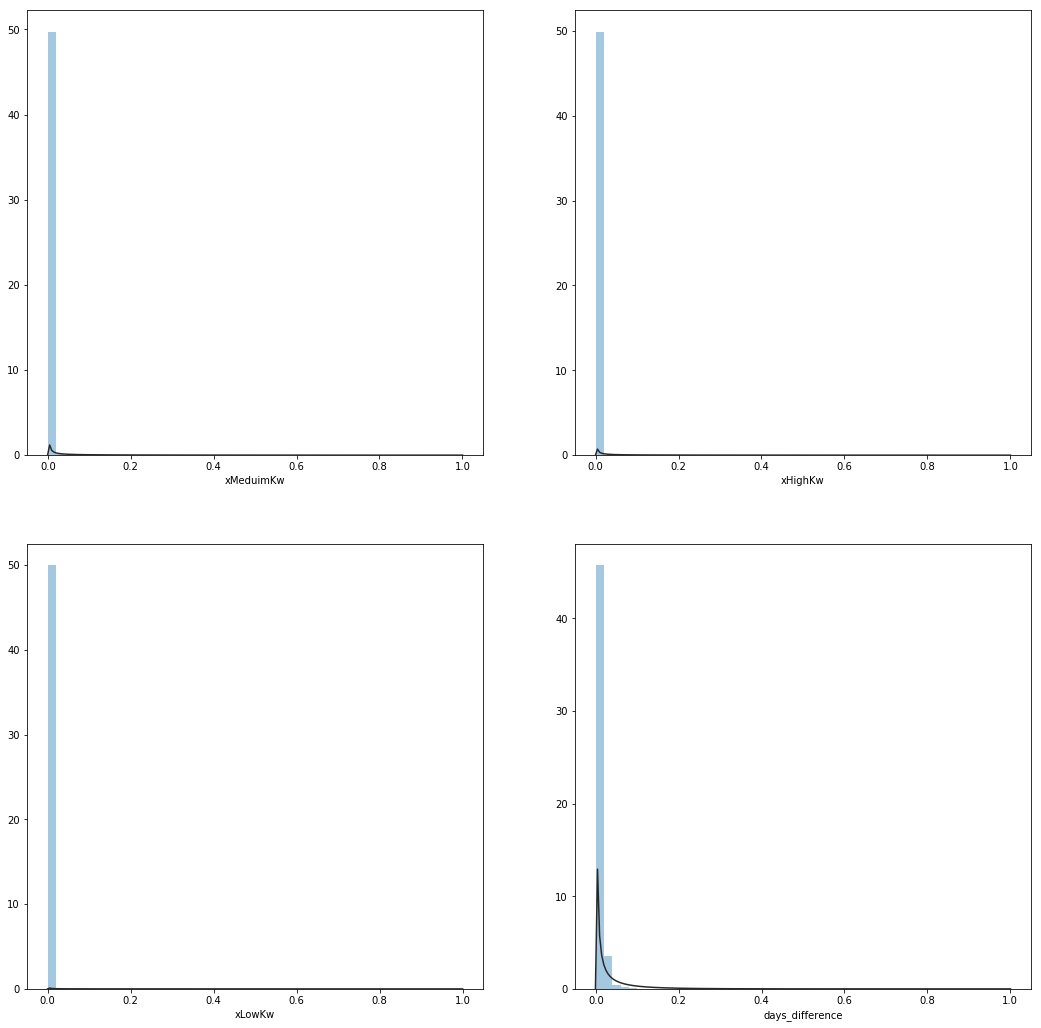

In [17]:
fig, ax =plt.subplots(2,2)
fig.set_size_inches(18, 18)

sns.distplot(df["xMeduimKw"], kde=False, fit=stats.gamma, ax=ax[0][0]);
sns.distplot(df["xHighKw"], kde=False, fit=stats.gamma, ax=ax[0][1]);
sns.distplot(df["xLowKw"], kde=False, fit=stats.gamma, ax=ax[1][0]);
sns.distplot(df["days_difference"], kde=False, fit=stats.gamma, ax=ax[1][1]);